TODOs

* use a proper mask. it should be tighter than the current one

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

N = 64

def get_squared_distance():
    """
    Return array of distances from the center
    """
    centered_indices = np.arange(N) - N // 2 + .5
    x, y = np.meshgrid(centered_indices, centered_indices)
    d = np.sqrt(x*x+y*y)
    return d

#obj = np.load('/Users/ollie/Downloads/data_recon.npz')
obj = np.load('recon_2x2_1x1_with_positions.npz')

import ptycho.tf_helper as hh

imgs, coords = obj['imgs'], obj['coords']

mask = hh.mk_centermask(imgs, N, 4, kind = 'center')
imgs = np.array(imgs * mask)
# imgs = imgs[:, 16:-16, 16:-16, :]
# imgs = imgs / imgs.mean()

from ptycho import probe
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = obj#np.load('/mnt/data/data (1).npz')
# imgs = torch.tensor(data['imgs'])
imgs = torch.tensor((imgs))
mask = torch.tensor(np.array(mask))

# # use tighter mask
# imgs = torch.tensor((imgs))
# mask = torch.tensor(np.array(mask))
probe_mask_real = (get_squared_distance() < N // 4)[..., None]
mask[...] = torch.tensor(probe_mask_real)
imgs = imgs * mask



def torch_cross_image_full(im1, im2, submean = False,
                          return_complex = False, convolve = False):
    # convolution instead of cross correlation
    # Subtract the mean
    if submean:
        im1_gray = im1 - torch.mean(im1, axis = [1, 2])[:, None, None]
        im2_gray = im2 - torch.mean(im2, axis = [1, 2])[:, None, None]
    else:
        im1_gray = im1 #- torch.mean(im1, axis = [1, 2])[:, None, None]
        im2_gray = im2 #- torch.mean(im2, axis = [1, 2])[:, None, None]
    
    # Zero-pad both images to double the size
    N = im1_gray.shape[-1] // 2
    im1_padded = torch.nn.functional.pad(im1_gray, (0, N, 0, N))
    im2_padded = torch.nn.functional.pad(im2_gray, (0, N, 0, N))
    
    # Compute FFT for both padded images
    fft_im1 = torch.fft.fft2(im1_padded)
    fft_im2 = torch.fft.fft2(im2_padded)
    
    # Multiply FFT of im1 with the complex conjugate of the FFT of reversed im2
#     product = fft_im1 * torch.conj(fft_im2.flip([-2, -1]))
    if convolve:
        product = fft_im1 * fft_im2
    else:
        product = fft_im1 * torch.conj(fft_im2)
    
    # Compute inverse FFT to get the cross-correlation
    cross_corr_complex = torch.fft.fftshift(torch.fft.ifft2(product))
    
    # Extract real component
    cross_corr_magnitude = torch.abs(cross_corr_complex)
    norm = torch.max(cross_corr_magnitude)
    
    if return_complex:
        return cross_corr_complex / norm
    
    return cross_corr_magnitude / norm

2023-10-26 16:26:05.757481: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-26 16:26:05.849583: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-26 16:26:06.255388: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2023-10-26 16:26:06.255433: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [17]:
np.savez('poscorrection_selfcontained.npz', imgs = imgs, mask = mask, coords = coords)

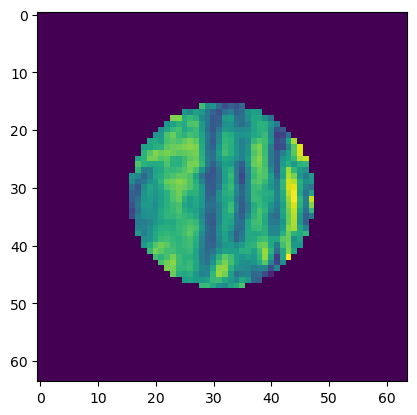

In [2]:
plt.imshow(np.abs(imgs[0, :, :, 0]))

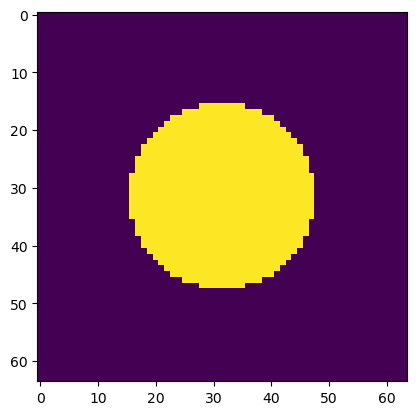

In [3]:
plt.imshow(np.abs(mask[0, :, :, 0]))

In [9]:
epsilon = 1
nn = 16#54
# ccorr_ref = torch_cross_image_full(imgs[:, :, :, 0], imgs[:, :, :, 0], convolve=False, submean = True)[:, nn: -nn, nn: -nn]


def channel_ccorr(imgs, i):
    ccorr = torch_cross_image_full(imgs[:, :, :, 0], imgs[:, :, :, i])[:,  nn: -nn, nn: -nn]
    ncorr = torch_cross_image_full(torch.abs(mask[:, :, :, 0]), torch.abs(mask[:, :, :, i]))[:, nn: -nn, nn: -nn]
    return (ccorr / (epsilon + np.abs(ncorr)))

gridsize = 2
ccorr2s = torch.stack(tuple(channel_ccorr(imgs, i) for i in range(gridsize**2)), dim=-1)

In [10]:
# ccorr2s[:, :mm, :, :] = 0
# ccorr2s[:, -mm:, :, :] = 0
# ccorr2s[:, :, :mm, :] = 0
# ccorr2s[:, :, -mm:, :] = 0

# TODO get weighted center of mass instead of center of mass of binary mask
# New function definition
def find_peak_positions(tensor, nominal_coords):
    b, N, _, c = tensor.shape
    result = torch.zeros((b, 1, 2, c), dtype=tensor.dtype)
    reshaped_tensor = tensor.view(b, N * N, c)
    max_val, _ = torch.max(reshaped_tensor, dim=1, keepdim=True)
    mask = (reshaped_tensor >= max_val * 0.85)
    x, y = torch.meshgrid(torch.arange(N), torch.arange(N))
    x = x.flatten().float()
    y = y.flatten().float()
    
    for i in range(c):
        channel_mask = mask[:, :, i]
        mass_x = torch.sum(x * channel_mask.float(), dim=1) / torch.sum(channel_mask, dim=1)
        mass_y = torch.sum(y * channel_mask.float(), dim=1) / torch.sum(channel_mask, dim=1)
        
        # cross correlation offsets are sign-flipped relative to the model's definition
        # Also, for the LCLS data we have to swap x and y
        result[:, 0, 0, i] = -mass_y
        result[:, 0, 1, i] = -mass_x
    
    # Shift so that the first-image relative coords are the same as their nominal coords under the model's
    # definition, which uses the solution region CM as origin
    result = result + N // 2 #+ nominal_coords[:1, ...]
    return result, mask

peak_positions, peakmasks = find_peak_positions(ccorr2s, coords)

# Show the shape and some content of the resulting tensor
peak_positions.shape, peak_positions[:1, :, :, :], coords[:1, ...]


/home/ollie/anaconda3/envs/tf/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484746322/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(torch.Size([25, 1, 2, 4]),
 tensor([[[[ 0.0000,  0.4576, -0.5833, -0.6667],
           [ 0.0000, -1.0847, -0.3333, -0.9333]]]]),
 array([[[[ 1.62183805, -0.64688545, -0.26744538, -0.70750723],
          [ 0.0848721 , -1.14667661, -0.34404734,  1.40585185]]]]))

In [11]:
def cmshift(peak_positions):
    return peak_positions - peak_positions.mean(axis = 3)[:, :, :, None]

In [12]:
from scipy.stats import pearsonr

In [13]:
ii = 1
pearsonr((peak_positions - peak_positions[:, :, :, :1])[:, :, ii, :].ravel(),
         (coords - coords[:, :, :, :1])[:, :, ii, :].ravel())

(0.30357890642158586, 0.002137526149105296)

In [14]:
pearsonr(cmshift(peak_positions)[:, :, ii, :].ravel(),
         cmshift(coords - coords[:, :, :, :1])[:, :, ii, :].ravel())

(0.1506264530816754, 0.13468605149898027)

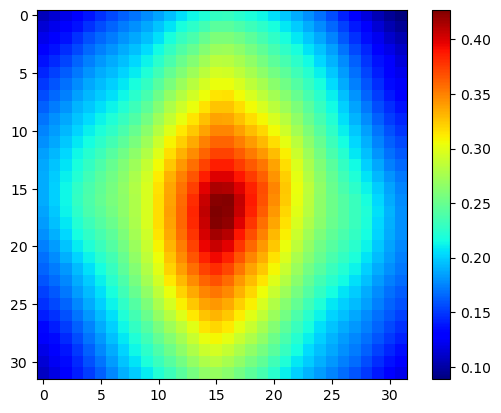

In [15]:
mm = 16
plt.imshow(ccorr2s[0, mm: -mm, mm: -mm, 1], cmap = 'jet')
plt.colorbar()

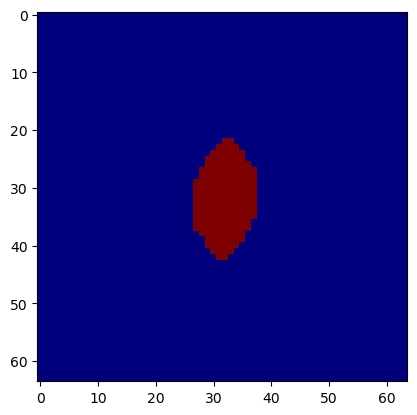

In [16]:
plt.imshow(ccorr2s[0, :, :, 0] >= (0.7 * ccorr2s[0, :, :, 0].max()), cmap = 'jet')


In [294]:
np.std(coords[:, :, 0, :].ravel()), np.std(coords[:, :, 1, :].ravel())

(0.9808277431607988, 0.9833094240361473)

In [268]:
coords[0]

array([[[ 1.62183805, -0.64688545, -0.26744538, -0.70750723],
        [ 0.0848721 , -1.14667661, -0.34404734,  1.40585185]]])

In [98]:
from scipy.ndimage.measurements import center_of_mass as cm